## Summary


In [1]:
'''
working
    DONE update the entry prompt
    
    provide examples
        overall question
        fuel tools
        maintenance tools

    work on the output final look
        as this will influence how the tools work
        have it mocked up but how do I connect it to the below pipeline?
        research and test some output examples. should come out of hte box for LLM
        feed in some examples

    create tools for my simple value version
        cars available
            use google or main website? how does tavily do for shopping
        federal tax credit info
            can tavily search a specific website
        TEST average maintenance costs
        TEST fuel and gas costs
        DONE LLM turns a monthly cost into a yearly cost
            adds the yearly costs
            can use existing math tools
            have to find a way to format the question correctly
            then get the output in a format that works
                ask the LLM or give a specific structured output?
        TRY WITH LLM FIRST formats the outputs correctly


    DONE get some version of it working
        STOPPED AT PLANNER
        may have to revert back to full tutorial code first to see
    DONE read through the tutorial
        rough outline
    DONE read through the paper
    DONE see the other tutorial examples in experimental
    

to do
    focus on buy only
        simple things first, make notes for where more improvements
        new / used
            by model and num miles
        federal tax credit only
        costs
            maintenance
                does this depend on miles driven per yer? startw ith default, let user change
            insurance
            registration
            fuel

    after initial question, ask for more details with an example
        new/used (and how many miles)
        type of car
        zip code / location
        mileage driven per year (fuel costs, maintenance costs)


    have to pass in the tool description I think
    
    review the output parser. may be able to repurpose some of these
        https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/#output-parser
    review the example tools. may be able to repurpose some of these
        https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/#math-tools

    write the tools
    organize tools

    incorporate old prototype notes
    incorporate other notes file

    read through the github code

    example prompts in the input or on the interface

    langsmith logging
    
    evaluation suite

concerns
    lot of new stuff here for me to digest
    will be much harder to get the minimal version up. maybe work on the smaller version simple one in parts at times too

    not really sure about the maintenance and fuel tools
        how to hook up
        how they work
        if the output being passed back is structured enough

questions
    not getting what the messages placeholder is filled in
    need to do a lot more research on other things that are available

References
# https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/
# https://arxiv.org/abs/2312.04511
# https://github.com/SqueezeAILab/LLMCompiler

backlog
    user feedback for correct or incorrect info
        for verifying rebate / maintenance info

    using like ab ackground process to get info for certain things rather than query from scratch every time
        lay out how things would be done long term if storing some results
            background process for updates to federal data
            background process for updates to state or local data, then cache and store in DB
                or the first time it is done then store it
            maybe for insurance info too
'''

'\nworking\n    \n    get some version of it working\n        STOPPED AT PLANNER\n        may have to revert back to full tutorial code first to see\n    DONE read through the tutorial\n        rough outline\n    DONE read through the paper\n    DONE see the other tutorial examples in experimental\n    \n\nto do\n    focus on buy only\n        simple things first, make notes for where more improvements\n        new / used\n            by model and num miles\n        federal tax credit only\n        costs\n            maintenance\n            insurance\n            registration\n            fuel\n\n    after initial question, ask for more details with an example\n        new/used (and how many miles)\n        type of car\n        zip code / location\n\n\n    have to pass in the tool description I think\n    \n    review the output parser. may be able to repurpose some of these\n        https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/#output-parser\n    review

### Constants and Imports

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

import getpass
import os

from langchain_core.tools import tool
import pgeocode


from IPython.display import Image, display

In [3]:
def _get_pass(var: str):
    if var not in os.environ:
        os.environ[var] = getpass.getpass(f"{var}: ")

_get_pass("OPENAI_API_KEY")
_get_pass("LANGSMITH_API_KEY")
_get_pass("TAVILY_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "EV Prototype LLMCompiler v0.01"


In [4]:
def display_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass


### Define tools

In [5]:
# @tool
# def get_state_and_city_from_zip_code(zip_code: str):
#     """Get the United States state and city from a five digit zip code
    
#     Returns:
#         state_name: str: The state name. 'unknown' if the zip code is invalid
#         place_name: str: The city name. 'unknown' if the zip code is invalid
#     """
#     unknown_value = 'unknown'

#     if zip_code is None or type(zip_code) is not str or len(zip_code) != 5:
#         state_name = unknown_value
#         place_name = unknown_value

#     else:
#         nomi = pgeocode.Nominatim('us')

#         results_df = nomi.query_postal_code(zip_code)

#         if results_df.shape[0] > 0:
#             state_name = results_df.state_name
#             place_name = results_df.place_name
#         else:
#             state_name = unknown_value
#             place_name = unknown_value

#     return state_name, place_name

# search = TavilySearchResults(
#     max_results=1,
#     description='tavily_search_results_json(query="the search query") - a search engine.',
# )

# test_tool_list = [
#     search,
#     get_state_and_city_from_zip_code,

# ]


In [6]:
from math_tools import get_math_tool

calculate = get_math_tool(ChatOpenAI(model="gpt-4-turbo-preview"))
search = TavilySearchResults(
    max_results=1,
    description='tavily_search_results_json(query="the search query") - a search engine.',
)

tools = [search, calculate]

### Planner

In [7]:

from typing import Sequence

from langchain import hub
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
from output_parser import LLMCompilerPlanParser, Task

prompt = hub.pull("wfh/llm-compiler")
print(prompt.pretty_print())

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

In [8]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )
    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

In [9]:
llm = ChatOpenAI(model="gpt-4-turbo-preview")
# This is the primary "agent" in our application
planner = create_planner(llm, tools, prompt)

In [10]:
example_question = "What's the temperature in SF raised to the 3rd power?"

for task in planner.stream([HumanMessage(content=example_question)]):
    print(task["tool"], task["args"])
    print("---")

description='tavily_search_results_json(query="the search query") - a search engine.' max_results=1 api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')) {'query': 'current temperature in San Francisco'}
---
name='math' description='math(problem: str, context: Optional[list[str]]) -> float:\n - Solves the provided math problem.\n - `problem` can be either a simple math problem (e.g. "1 + 3") or a word problem (e.g. "how many apples are there if there are 3 apples and 2 apples").\n - You cannot calculate multiple expressions in one call. For instance, `math(\'1 + 3, 2 + 4\')` does not work. If you need to calculate multiple expressions, you need to call them separately like `math(\'1 + 3\')` and then `math(\'2 + 4\')`\n - Minimize the number of `math` actions as much as possible. For instance, instead of calling 2. math("what is the 10% of $1") and then call 3. math("$1 + $2"), you MUST call 2. math("what is the 110% of $1") instead, which will reduce the number of 

### Task Fetching Unit

In [11]:
import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict


def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [12]:
import itertools


@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

### Joiner

In [13]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response/answer."""

    response: str


class Replan(BaseModel):
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""

    thought: str = Field(
        description="The chain of thought reasoning for the selected action"
    )
    action: Union[FinalResponse, Replan]


joiner_prompt = hub.pull("wfh/llm-compiler-joiner").partial(
    examples=""
)  # You can optionally add examples
llm = ChatOpenAI(model="gpt-4-turbo-preview")

runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)

In [14]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}


joiner = select_recent_messages | runnable | _parse_joiner_output

### Compose using LangGraph

In [15]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile()

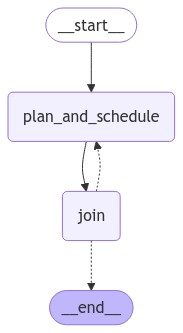

In [16]:
display_graph(chain)

### Sample Execution

In [17]:
for step in chain.stream(
    {"messages": [HumanMessage(content="What's the GDP of New York?")]}
):
    print(step)
    print("---")

{'plan_and_schedule': {'messages': [FunctionMessage(content="[{'url': 'https://www.investopedia.com/articles/investing/011516/new-yorks-economy-6-industries-driving-gdp-growth.asp', 'content': 'The manufacturing sector is a leader in railroad rolling stock, as many of the earliest railroads were financed or founded in New York; garments, as New York City is the fashion capital of the U.S.; elevator parts; glass; and many other products.\\n Educational Services\\nThough not typically thought of as a leading industry, the educational sector in New York nonetheless has a substantial impact on the state and its residents, and in attracting new talent that eventually enters the New York business scene. New York has seen a large uptick in college attendees, both young and old, over the 21st century, and an increasing number of new employees in other New York sectors were educated in the state. New York City is the leading job hub for banking, finance, and communication in the U.S. New York i

In [18]:
# Final answer
print(step["join"]["messages"][-1].content)

The GDP of New York is $1.7 trillion.


#### Testing the math tools

In [19]:
for step in chain.stream(
    {"messages": [HumanMessage(content="If the car insurance is $120 per month, how much is it per year?")]}
):
    print(step)
    print("---")

print(step["join"]["messages"][-1].content)


{'plan_and_schedule': {'messages': [FunctionMessage(content='1440', additional_kwargs={'idx': 1, 'args': {'problem': '120 * 12'}}, response_metadata={}, name='math', id='867dbf43-1505-4daf-ae0e-b45aed598dae', tool_call_id=1)]}}
---
{'join': {'messages': [AIMessage(content="Thought: The calculation to find the yearly cost of car insurance is straightforward: $120/month * 12 months/year = $1440/year. This directly answers the user's question.", additional_kwargs={}, response_metadata={}, id='cf14cb9b-b344-4db2-bf15-ec4a7ae04fb8'), AIMessage(content='The car insurance costs $1440 per year if it is $120 per month.', additional_kwargs={}, response_metadata={}, id='42c58b73-f06b-40a2-a2f2-dc8f8b9c0fc7')]}}
---
The car insurance costs $1440 per year if it is $120 per month.


### Execution